<h2 style="text-align:center"> <font color="blue"> Prédiction du nombre de nuits de logement d'urgence accordé à un groupe d'individus </font></h2>


---------------------------------------

## Setup

In [2]:
import os
os.environ['PYTHONHASHSEED']='0' # get reproducible results 

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import xgboost as xgb

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf

## Loss function

In [3]:
def loss_scorer(y_true, y_pred):
    
    return log_loss(y_true, y_pred, sample_weight=10**y_true)

## Description data

#### File requests_train.csv

| Field name                       | Description                                                                                                                                                        | Type                     |
|----------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------|
| request\_id                      | "the id of request, which is unique in this dataset\."                                                                                                             | string                   |
| animal\_presence                 | flage indicating whether an animal is accompanying the group                                                                                                       | boolean                  |
| answer\_creation\_date           | the timestamp when the anwer was registered                                                                                                                        | timestamp \(iso format\) |
| child\_situation                 | the number representing the situation of the children in the group \(if any\)                                                                                      | integer                  |
| child\_to\_come                  | flag indicating whether the group is expecting a baby                                                                                                              | boolean                  |
| district                         | the id of the administrative district where the request is made\. Each district has its own emergency center responsible for receiving and managing the requests\. | integer                  |
| granted\_number\_of\_nights      | "the target \(train dataset only\), the categorized number of nights granted to the request"                                                                       | integer                  |
| group\_composition\_id           | the number representing the group composition                                                                                                                      | integer                  |
| group\_composition\_label        | the description of the group composition                                                                                                                           | string                   |
| group\_creation\_date            | the timestamp when the group was created in the database                                                                                                           | timestamp \(iso format\) |
| group\_id                        | "the id of the group\. A group can be linked to several requests, so not unique"                                                                                   | string                   |
| group\_main\_requester\_id       | the id of the individual making the request\. it cannot be joined with individual\_id                                                                              | string                   |
| group\_type                      | whether the group is a made of several people \(GROUP\) or just one person \(PERSON\)                                                                              | string                   |
| housing\_situation\_id           | the id of the housing situation of the group when making the request                                                                                               | integer                  |
| housing\_situation\_label        | the description of the housing situation of the group when making the request                                                                                      | string                   |
| long\_term\_housing\_request     | flag indicating whether the groupe has filed a request for a long term housing solution\.                                                                          | boolean                  |
| number\_of\_underage             | the number of individual under 18 in the group                                                                                                                     | integer                  |
| request\_backoffice\_creator\_id | the id of the emergency call center employee who received the request                                                                                              | string                   |
| request\_creation\_date          | the timestamp when the request was made\.                                                                                                                          | timestamp \(iso format\) |
| requester\_type                  | the type of person who called the emergency service \(a user / a social patrol / a third party\)                                                                   | string                   |
| social\_situation\_id            | the id representing the social situation of the group in the database                                                                                              | string                   |
| town                             | the town where the requester is living                                                                                                                             | string                   |
| victim\_of\_violence             | flag indicating whether the group includes an individual victim of violence                                                                                        | boolean                  |
| victim\_of\_violence\_type       | type of the individual victim of violence \(and if it is a case of domestic violence\)                                                                             | string                   |


In [4]:
requests_train = pd.read_csv(filepath_or_buffer='data/requests_train.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

requests_test = pd.read_csv(filepath_or_buffer='data/requests_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)


requests_train.head()

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type
0,130667d2964de43c511d0ead7ac66b33,f,2019-02-11 22:30:00,-1,NaN,85,1,10,man alone,2018-05-03 12:10:40.416,...,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-11 22:30:00,third party,9a84febc47fedaf2c81d7c755e9edc85,NaN,f,NaN
1,b1cd62fcf24eebb0f685d5eaf55317a8,f,2019-02-12 09:00:00,-1,NaN,85,1,10,man alone,2019-03-07 12:11:08.545,...,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-12 09:00:00,user,11f64f0547e855c5c59329b9edc63063,NaN,f,NaN
2,12cc0a18890bd4959fe42df3ae58838e,f,2019-02-01 21:00:00,-1,NaN,59,1,80,isolated child/underage,2019-03-13 12:54:15.887,...,street,NaN,-1,686d962128c7622aa79ed91da13f5c77,2019-02-01 21:00:00,user,898ab2883f410f4c6fb042ef16329fbb,NaN,f,NaN
3,ae2d5b4dc181d29e430132f145da1556,f,2019-02-25 15:12:05.037,-1,NaN,50,2,20,woman alone,2018-10-09 14:37:29.773,...,NaN,NaN,-1,ec29519464c381a6630f4e480a0c000e,2019-02-25 15:12:05.037,user,3998c8e890ddc980527dd1af45dfa672,NaN,t,woman
4,d13a17ce36c832514fda2464e11c4a9f,f,2019-02-20 09:59:20.603,-1,NaN,93,2,60,group with child(ren),2018-10-02 10:47:36.931,...,hotel paid by the emergency centre,NaN,-1,c8b5cc926b1d7212224a08baa9619518,2019-02-20 09:59:20.603,user,74a10d96eae43586bc3c46e89719b821,NaN,f,NaN


#### File individuals_train.csv

| Field name                      | Description                                                                                                               | Type                     |
|---------------------------------|---------------------------------------------------------------------------------------------------------------------------|--------------------------|
| request\_id                     | the id of the request\. It is not unique in this dataset \(a request can be for several individual in case of a group\)\. | string                   |
| individual\_id                  | the id of the individual                                                                                                  | string                   |
| birth\_month                    | month of birth of the individual                                                                                          | integer                  |
| birth\_year                     | the year of birth of the individual                                                                                       | integer                  |
| childcare\_center\_supervision  | flag representing the fact that a child receives follow\-up care                                                          | boolean                  |
| disabled\_worker\_certification | flag representing the fact that an individual is considered disabled regarding the employement law                        | boolean                  |
| gender                          | the gender of the individual                                                                                              | boolean                  |
| housing\_situation\_2\_id       | housing situation category number of the group when making the request \(more precise\)                                   | integer                  |
| housing\_situation\_2\_label    | description of the housing situation of the group when making the request \(more precise\)                                | string                   |
| individual\_creation\_date      | timestamp of the individual creation in the database                                                                      | timestamp \(iso format\) |
| individual\_role                | description of the role of the individual                                                                                 | string                   |
| individual\_role\_2\_id         | category number of the role of the individual                                                                             | integer                  |
| individual\_role\_2\_label      | "description of the role of the individual, more precise than the former"                                                 | string                   |
| marital\_status\_id             | id of the marital status of the individual                                                                                | integer                  |
| marital\_status\_label          | description of the marital status of the individual                                                                       | string                   |
| pregnancy                       | flag representing whether the individual is pregnant \(if applicable\)                                                    | boolean                  |


In [5]:
individuals_train = pd.read_csv(filepath_or_buffer='data/individuals_train.csv',
                                sep=',',
                                low_memory=False,
                                error_bad_lines=False)

individuals_test = pd.read_csv(filepath_or_buffer='data/individuals_test.csv',
                               sep=',',
                               low_memory=False,
                               error_bad_lines=False)

individuals_train.head()

,request_id,individual_id,housing_situation_2_id,housing_situation_2_label,birth_month,birth_year,childcare_center_supervision,disabled_worker_certification,gender,individual_creation_date,individual_role,individual_role_2_id,individual_role_2_label,marital_status_id,marital_status_label,pregnancy
0,130667d2964de43c511d0ead7ac66b33,b24a8cfaaf3663bac45ca3bcd24f0b36,20,on the street,5,1977,NaN,NaN,male,2018-01-29,isolated person,30,isolated adult,10,single person,f
1,b1cd62fcf24eebb0f685d5eaf55317a8,eef783d1bda82661a751c12c34aff8c2,20,on the street,5,1980,NaN,NaN,male,2019-03-07,NaN,30,isolated adult,-1,NaN,f
2,12cc0a18890bd4959fe42df3ae58838e,927b6fa58d6be263c411332835b11fec,20,on the street,1,2003,NaN,NaN,male,2019-03-13,NaN,10,isolated underage/child,-1,NaN,f
3,ae2d5b4dc181d29e430132f145da1556,94181d5cf4a56cc84d12677df84e2e03,20,on the street,7,1986,NaN,NaN,female,2018-10-09,NaN,30,isolated adult,-1,NaN,f
4,d13a17ce36c832514fda2464e11c4a9f,e79d2e3f9ace50049f1796c098008c13,35,hotel paid by the emergency structure,9,1980,NaN,NaN,female,2017-06-22,husband/spouse,1,partner,-1,NaN,f


## Preprocessing data

- Convert categorical variable into dummy

In [6]:
features = ['gender', 'pregnancy', 'marital_status_label']
    
dummies = pd.get_dummies(individuals_train[features], drop_first=True) 
individuals_train = pd.concat([individuals_train.drop(features, axis=1), dummies])

dummies = pd.get_dummies(individuals_test[features], drop_first=True) 
individuals_test = pd.concat([individuals_test.drop(features, axis=1), dummies])

In [7]:
features = ['animal_presence', 'child_to_come', 'group_type', 'requester_type', 'victim_of_violence', 'long_term_housing_request']
    
dummies = pd.get_dummies(requests_train[features], drop_first=True) 
requests_train = pd.concat([requests_train.drop(features, axis=1), dummies])

dummies = pd.get_dummies(requests_test[features], drop_first=True) 
requests_test = pd.concat([requests_test.drop(features, axis=1), dummies])


- Merge data individuals et requests

In [8]:
df_train = pd.merge(requests_train, 
                    individuals_train.groupby(['request_id']).mean(), 
                    left_on='request_id',
                    right_index=True)

df_test = pd.merge(requests_test, 
                    individuals_test.groupby(['request_id']).mean(), 
                    left_on='request_id',
                    right_index=True)

df_train.head()

,request_id,answer_creation_date,child_situation,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,group_id,group_main_requester_id,...,marital_status_id,gender_male,pregnancy_t,marital_status_label_cohabitation,marital_status_label_divorced,marital_status_label_marital relationship,marital_status_label_married,marital_status_label_separated,marital_status_label_single person,marital_status_label_widowed
0,130667d2964de43c511d0ead7ac66b33,2019-02-11 22:30:00,-1.0,85.0,1.0,10.0,man alone,2018-05-03 12:10:40.416,c62f692dcc3f31880dd3937369c6f9e1,56252a8182a732cad0d106328bf96a0b,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b1cd62fcf24eebb0f685d5eaf55317a8,2019-02-12 09:00:00,-1.0,85.0,1.0,10.0,man alone,2019-03-07 12:11:08.545,cbb3ae0239a3ca9a0441831bde02aaa3,b23d21c9973e5b74504a94eebe82fb75,...,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12cc0a18890bd4959fe42df3ae58838e,2019-02-01 21:00:00,-1.0,59.0,1.0,80.0,isolated child/underage,2019-03-13 12:54:15.887,a73d85877e940fd36ac23bb80ac7fbbe,5e063c21a61a5b38f8f21baebea86f50,...,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ae2d5b4dc181d29e430132f145da1556,2019-02-25 15:12:05.037,-1.0,50.0,2.0,20.0,woman alone,2018-10-09 14:37:29.773,5f69b8b928f84ce1e673740acb854af2,f46e831e036fe418d88d6d40ee4b0680,...,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d13a17ce36c832514fda2464e11c4a9f,2019-02-20 09:59:20.603,-1.0,93.0,2.0,60.0,group with child(ren),2018-10-02 10:47:36.931,df3a2364091c2aa9f90f2738f6b176f1,936ae1e1737f38e8f9ef3049805629f3,...,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


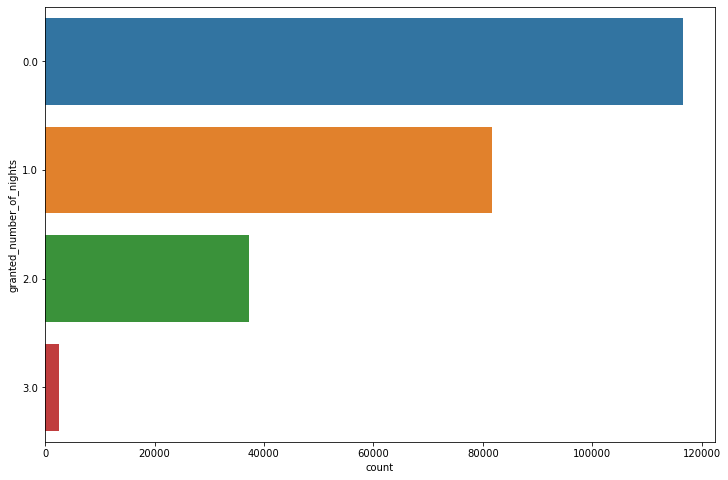

In [9]:
fig = plt.figure(figsize=(12, 8))
ax = sns.countplot(y="granted_number_of_nights", data=df_train, order=df_train['granted_number_of_nights'].value_counts().index)
plt.show()

- Supprimer les variables avec une forte présence de NA

In [10]:
vars_na = df_train.isna().sum() / df_train.shape[0]
vars_na = list(vars_na[vars_na > 0.6].index)
df_train.drop(vars_na, axis=1, inplace=True)
df_test.drop(vars_na, axis=1, inplace=True)

vars_na

['town',
 'victim_of_violence_type',
 'animal_presence_t',
 'child_to_come_t',
 'group_type_individual',
 'requester_type_third party',
 'requester_type_user',
 'victim_of_violence_t',
 'long_term_housing_request_t',
 'gender_male',
 'pregnancy_t',
 'marital_status_label_cohabitation',
 'marital_status_label_divorced',
 'marital_status_label_marital relationship',
 'marital_status_label_married',
 'marital_status_label_separated',
 'marital_status_label_single person',
 'marital_status_label_widowed']

- Supprimer les variables non pertinentes 

In [11]:
features = ['request_id', 'answer_creation_date', 'child_situation', 'group_composition_label', 
            'group_creation_date', 'group_id', 'group_main_requester_id', 'social_situation_id', 
            'housing_situation_label', 'request_backoffice_creator_id', 'request_creation_date', 
            'marital_status_id', 'birth_month']

df_train.drop(features, axis=1, inplace=True)
df_test.drop(features, axis=1, inplace=True)

- Dataframe final

In [12]:
df_train.isna().sum()

district                    0
granted_number_of_nights    0
group_composition_id        0
housing_situation_id        0
number_of_underage          0
housing_situation_2_id      0
birth_year                  0
individual_role_2_id        0
dtype: int64

## Training 

- Fixer le grain aléatoire(seed)

In [13]:
def set_random_seed():
    seed = 0
    os.environ['PYTHONHASHSEED']=str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.compat.v1.set_random_seed(seed) 
    
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

    

- Splitter data en train-test

In [14]:
X = df_train.drop(['granted_number_of_nights'], axis=1)
y = df_train['granted_number_of_nights']

X_test = df_test.drop(['granted_number_of_nights'], axis=1)
y_test = df_test['granted_number_of_nights']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print('X_train: ', X_train.shape)
print('X_valid: ', X_valid.shape)
print('X_test: ', X_test.shape)


X_train:  (166733, 7)
X_valid:  (71458, 7)
X_test:  (59548, 7)


#### Modèle aléatoire

In [15]:
preds = np.random.uniform(size=(X_test.shape[0], 4))
score = loss_scorer(y_test, preds)

print(f'Score modèle aléatoire: {score}')

Score modèle aléatoire: 1.6192273733608613


#### Ensemble learning ([XGBoost](https://xgboost.readthedocs.io/en/latest/))
- XGBoost est une implémentation optimisée du Gradient Boosting

- Gradient Boosting : algorithme d'apprentissage supervisé basé sur le principe de la combinaison de modèles faibles pour fournir une meilleure prédiction.

- XGBoost construit un premier modèle. Ensuite, chaque observation sera pondérée en fonction de la performance de la prédiction. On itère le processus...

In [16]:
dtrain = xgb.DMatrix(X_train, label=y_train, weight=10**y_train, feature_names=X.columns)
dvalid = xgb.DMatrix(X_valid, label= y_valid, weight= 10**y_valid, feature_names=X.columns)
dtest = xgb.DMatrix(X_test, feature_names=X.columns)

param = {
    'max_depth': 3,
    'objective': 'multi:softprob',  
    'eval_metric': 'mlogloss',
    'num_class': 4}  

# Fixer le seed
set_random_seed()

# Train XGBoost
modelxgb = xgb.train(param, dtrain, num_boost_round=1000, evals=[(dvalid, 'valid')], early_stopping_rounds=100, verbose_eval=100)


[0]	valid-mlogloss:1.17336
[100]	valid-mlogloss:0.60661
[200]	valid-mlogloss:0.58617
[300]	valid-mlogloss:0.58080
[400]	valid-mlogloss:0.58160
[425]	valid-mlogloss:0.58293


In [17]:
preds = modelxgb.predict(dtest)
score = loss_scorer(y_test, preds)
print(f'XGBoost score : {score}')

XGBoost score : 0.5918754141102349


#### Feature importance

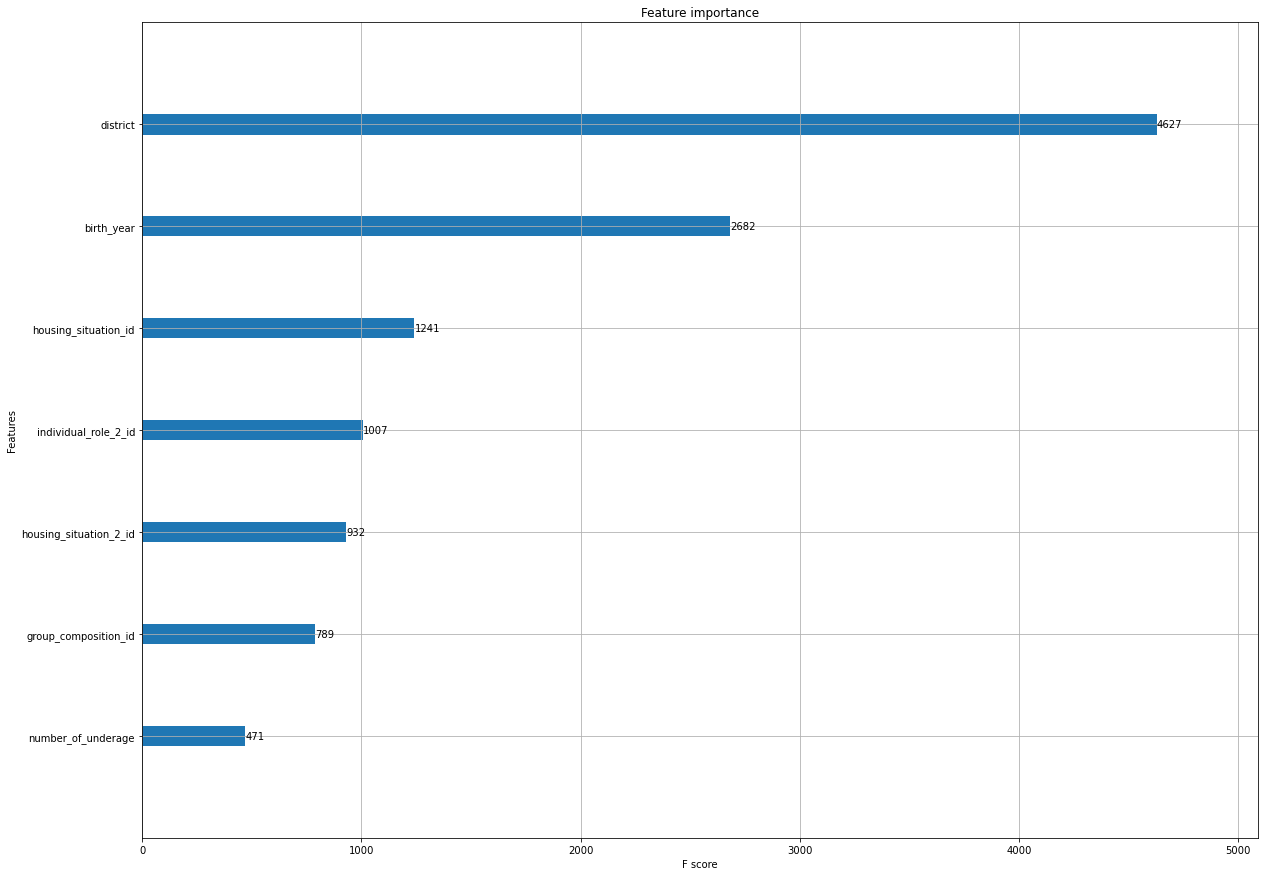

In [18]:
plt.rcParams["figure.figsize"] = (20, 15)
xgb.plot_importance(modelxgb)
plt.show()

- Pour plus de détails sur le projet, contacter moi par email: <h6>  alhousseynou.ball@polytechnique.edu <h6>

<br>
